# Analysis of Chest X-Ray images

### Problem Statement

Neural networks have revolutionised image processing in several different domains. Among these is the field of medical imaging. 
In the following notebook, we will get some hands-on experience in working with Chest X-Ray (CXR) images.
The chest X-Ray images we have are divided into 2 folders, one which have effusion detected, and the other are normal X-rays.
If you want to know more about what is "Pleural effusion", read the articles below. 

Here is a quick explanation, from the first link below. 

__Pleural effusion, sometimes referred to as “water on the lungs,” is the build-up of excess fluid between the layers of the pleura outside the lungs. 
The pleura are thin membranes that line the lungs and the inside of the chest cavity and act to lubricate and facilitate breathing. 
Normally, a small amount of fluid is present in the pleura.__

The objective of this exercise is 2 fold. 

 1. To identify images where an "effusion" is present. This is a classification problem, where we will be dealing with two classes - 'effusion' and 'nofinding'. Here, the latter represents a "normal" X-ray image. 
 This same methodology can be used to spot various other illnesses that can be detected via a chest x-ray. For the scope of this demonstration, we will specifically deal with "effusion".
 2. To prepare a training script that can run in a distributed ML environment

 About Pleural effusion
 - https://my.clevelandclinic.org/health/diseases/17373-pleural-effusion-causes-signs--treatment#:~:text=Pleural%20effusion%2C%20sometimes%20referred%20to,to%20lubricate%20and%20facilitate%20breathing.
 - https://www.webmd.com/lung/pleural-effusion-symptoms-causes-treatments


## 1. Data Pre-processing

Our data is in the form of grayscale (black and white) images of chest x-rays. 
To perform our classification task effectively, we need to perform some pre-processing of the data.

First, we load all the relevant libraries.

In [1]:
# !pip install opencv-python
# !pip install matplotlib
# !pip install tensorflow==2.4.1
# !pip install keras==2.3.1
# !pip install 'h5py<3.0.0'
# !pip install pydot

In [2]:
import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import warnings

import azureml
from azureml.core import Experiment
from azureml.core import Workspace, Run
from azureml.core import Environment
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.telemetry import set_diagnostics_collection
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.core.authentication import InteractiveLoginAuthentication

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from platform import python_version
from keras.utils import plot_model

import random as rn
import tensorflow as tf
import keras as k

rn.seed(30)
np.random.seed(30)
tf.compat.v1.random.set_random_seed(30)
set_diagnostics_collection(send_diagnostics=False)
print(python_version())
print(tf.__version__)
warnings.simplefilter('ignore')


3.8.1
2.3.0


Using TensorFlow backend.


### Login and configure Azure ML Workspace

In [3]:
interactive_auth = InteractiveLoginAuthentication(tenant_id="72f988bf-86f1-41af-91ab-2d7cd011db47")
ws = Workspace(subscription_id="925a5ad8-a21a-48c0-92a2-5a8a2a4dfc46",
               resource_group="ml-workbench",
               workspace_name="ml-workbench-eu",
               auth=interactive_auth)

In [4]:
# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.27.0


In [5]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

Workspace name: ml-workbench-eu
Azure region: eastus
Subscription id: 925a5ad8-a21a-48c0-92a2-5a8a2a4dfc46
Resource group: ml-workbench


### Download the dataset

In [6]:
from azureml.core.dataset import Dataset

web_paths = [
                'https://mlworkbencheu2397988138.blob.core.windows.net/datasets/data.zip'
            ]
dataset = Dataset.File.from_files(path=web_paths)

### Registering the dataset so that it can be used across workspace

In [7]:
dataset_registered = False
try:
    temp = Dataset.get_by_name(workspace = ws, name = 'effusion-dataset')
    dataset_registered = True
except:
    print("The dataset effusion-dataset is not registered in workspace yet.")

if not dataset_registered:
    dataset = dataset.register(workspace = ws,
                               name = 'effusion-dataset',
                               description='training and test dataset',
                               create_new_version=True)
# list the files referenced by dataset
dataset.to_path()

['/data.zip']

### Configure Compute Target

Note: We can also create compute target here if it does not exist. Saving time by pre-creating the compute target. 
In the first few samples we will use a single node, later we will use a cluster for distributed training.

In [8]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "gpu-instance-small"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
except ComputeTargetException:
    print('Compute Target does not exist...')

Downloading the data to local machine. 
Azure ML by default mounts the dataset as network drive which is slower than local data.

In [9]:
dataset.download('/tmp/data/', overwrite=True)

['/tmp/data/data.zip']

In [10]:
!mkdir -p /var/tmp/effusion
!cp /tmp/data/data.zip /var/tmp/effusion
!unzip -qq -o /var/tmp/effusion/data.zip -d /var/tmp/effusion/

In [11]:
DATASET_PATH = '/var/tmp/effusion/data'

# There are two classes of images that we will deal with
disease_cls = ['effusion', 'nofinding']

print('Number of effusion images..',len([name for name in os.listdir(os.path.join(DATASET_PATH, 'effusion'))]))
print('Number of No finding images..',len([name for name in os.listdir(os.path.join(DATASET_PATH, 'nofinding'))]))

Number of effusion images.. 107
Number of No finding images.. 1000


As you may notice the dataset is heavily imbalanced which should be treated before training.

Next, we read the "effusion" and "nofinding" images.

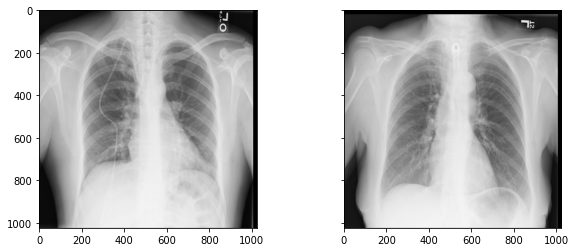

In [12]:
effusion_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
effusion = glob.glob(effusion_path)
effusion = cv2.imread(effusion[0])

normal_path = os.path.join(DATASET_PATH, disease_cls[1], '*')
normal = glob.glob(normal_path)
normal = cv2.imread(normal[0])

f, axes = plt.subplots(1, 2, sharey=True)
f.set_figwidth(10)
    
axes[0].imshow(effusion, cmap='gray')
axes[1].imshow(normal, cmap='gray')

In [13]:
print('Shape of images..')
effusion.shape, normal.shape

Shape of images..


((1024, 1024, 3), (1024, 1024, 3))

Next we run some image transformations to improve the training quality and make the model more robust.

The below transformations will be applied to trianing samples.

(256, 256, 3)


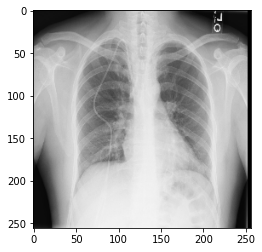

In [14]:
# Resizing the image to 256,256
resized_img = cv2.resize(effusion, (256,256), interpolation = cv2.INTER_NEAREST)
plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
print(resized_img.shape)

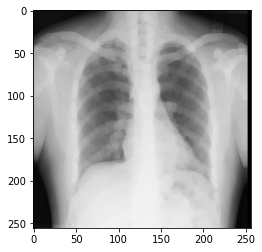

In [15]:
# Applying morphological transformations. 
# There are 3 types of morphological transformations
# 1. Erosion - Erosion shrinks bright regions and enlarges dark regions
# 2. Dilation - Dilation shrinks dark regions and enlarges bright regions.
# 3. Opening - Erosion followed by dilation. This is used to remove small bright spots and connect small dark spots. 
# helps in opening up dark spots between bright regions
# 4. Closing - Dilation followed by erosion. This removes dark spots between white regions. 

# Since we are more focused on the white regions near the lungs, I'm using Opening. 
# Also if you notice the images below the problem is more noticable when opened. 
kernel = np.ones((5,5),np.uint8)
opened = cv2.morphologyEx(resized_img, cv2.MORPH_OPEN, kernel)
plt.imshow(opened)

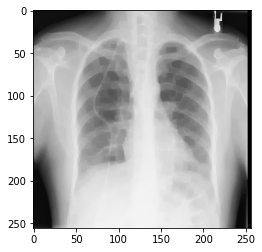

In [16]:
kernel = np.ones((5,5),np.uint8)
opened = cv2.morphologyEx(resized_img, cv2.MORPH_CLOSE, kernel)
plt.imshow(opened)

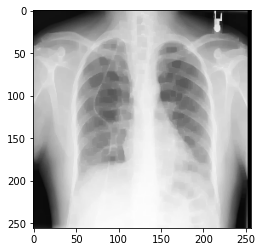

In [17]:
# Normalizing the image
normalizedImg = np.zeros((256, 256))
plt.imshow(cv2.normalize(opened, normalizedImg, 0, 255, cv2.NORM_MINMAX))

Few more techniques we can experiment with are. 
- Cropping the image. 
- Rotating the image <10 degree

### Data Augmentation ###

Now that we have read the images, the next step is data augmentation.

In this re-usable method we will also apply slight rotation for training data. 

In [18]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0,
    height_shift_range=0,
    vertical_flip=False,)

def preprocess_img(img, mode):
    normalizedImg = np.zeros((256, 256))
    resized_img = cv2.resize(img, (256,256))
    normalized_img = cv2.normalize(resized_img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)[:,:,np.newaxis]
    if mode == 'train':
        if np.random.randn() > 0:
            kernel = np.ones((5,5),np.uint8)
            opened = cv2.morphologyEx(normalized_img, cv2.MORPH_OPEN, kernel)[:,:,np.newaxis]
            normalized_img = datagen.random_transform(opened)
    return normalized_img

Before pre processing image....
/var/tmp/effusion/data/effusion/00007633_000.png
shape.. (1024, 1024)


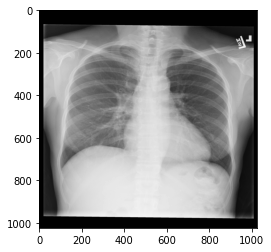

In [19]:
## Output of the final pre-processing message, with few random transformation

img_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
imgs = glob.glob(img_path)
image_id = 8
print('Before pre processing image....')
print(imgs[image_id])
img = cv2.imread(imgs[image_id], cv2.IMREAD_GRAYSCALE)
print('shape..', img.shape)
plt.imshow(img,cmap='gray')

After pre processing image....
shape.. (256, 256)


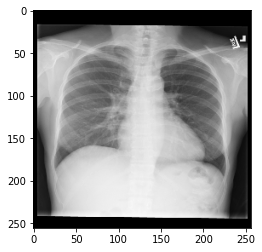

In [20]:
processed_img = preprocess_img(img[:, :, np.newaxis], 'train')
print('After pre processing image....')
print('shape..',processed_img[:,:,0].shape)
plt.imshow(processed_img[:,:,0],cmap='gray')

## 2. Model building

Let us build a CNN model.

In [21]:
from tensorflow.keras.metrics import AUC

img_channels = 1
img_rows = 256
img_cols = 256
nb_classes = 1

cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_rows,img_cols,img_channels)))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu',))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(128, (3, 3), padding='same', activation='relu',))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Flatten())
cnn.add(Dense(512))
cnn.add(Dense(512))
cnn.add(Dense(nb_classes,activation='sigmoid'))
cnn.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0

In [22]:
import numpy as np

class AugmentedDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, disease_cls = ['nofinding', 'effusion'], 
                 batch_size=32, dim=(256, 256), n_channels=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode
        
        for i, cls in enumerate(disease_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:int(len(paths)*ablation/100)]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
        
            
        self.n_channels = n_channels
        self.n_classes = len(disease_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            img = cv2.imread(ID, cv2.IMREAD_GRAYSCALE)
            img = img[:, :, np.newaxis]
            if img.shape[:3] == (1024, 1024,1):
                img = preprocess_img(img, self.mode)
                X[i,] = img
                y[i] = self.labels[ID]
            else:
                delete_rows.append(i)
                continue
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        # return y since we have only 2 categories, for multi-class this needs to be converted into
        # one hot encoded vector.
        return X, y

### Ablation Run

An ablation run is when you systematically modify certain parts of the input, in order to observe the equivalent change in the input.

For the following section, we'll be using the Data Generator concept that you previously worked on.

In [23]:
training_generator = AugmentedDataGenerator('train', ablation=50)
validation_generator = AugmentedDataGenerator('val', ablation=50)

cnn.fit(training_generator, epochs=1, validation_data=validation_generator)

13/13 [==============================] - 8s 596ms/step - loss: 0.3514 - accuracy: 0.8462 - auc: 0.4623 - val_loss: 0.2870 - val_accuracy: 0.9167 - val_auc: 0.5497


In [24]:
training_generator = AugmentedDataGenerator('train', ablation=5)

cnn.fit(training_generator, epochs=5, validation_data=None)

Epoch 1/5
1/1 [==============================] - 0s 86ms/step - loss: 0.3006 - accuracy: 0.9062 - auc: 0.6954
Epoch 2/5
1/1 [==============================] - 0s 85ms/step - loss: 0.3001 - accuracy: 0.9062 - auc: 0.7299
Epoch 3/5
1/1 [==============================] - 0s 85ms/step - loss: 0.3093 - accuracy: 0.9062 - auc: 0.5977
Epoch 4/5
1/1 [==============================] - 0s 85ms/step - loss: 0.3199 - accuracy: 0.9062 - auc: 0.4253
Epoch 5/5
1/1 [==============================] - 0s 86ms/step - loss: 0.3150 - accuracy: 0.9062 - auc: 0.5460


In [25]:
from sklearn.metrics import roc_auc_score
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *

class roc_callback(Callback):
    """ ROC callback : Calculates the validation AUC and adds it to the dictionary """
    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

In [26]:
# Validating AUC callback
training_generator = AugmentedDataGenerator('train', ablation=20)
validation_generator = AugmentedDataGenerator('val', ablation=20)
auc_logger = roc_callback()
history = cnn.fit(training_generator, epochs=5, validation_data=validation_generator, callbacks=[auc_logger])

Epoch 1/5
5/5 [==============================] - ETA: 0s - loss: 0.3192 - accuracy: 0.9000 - auc: 0.6302
Val AUC for epoch0: 0.5517241379310345
5/5 [==============================] - 4s 711ms/step - loss: 0.3192 - accuracy: 0.9000 - auc: 0.6302 - val_loss: 0.2546 - val_accuracy: 0.9375 - val_auc: 0.4500
Epoch 2/5
5/5 [==============================] - ETA: 0s - loss: 0.3027 - accuracy: 0.9062 - auc: 0.6179
Val AUC for epoch1: 0.45977011494252873
5/5 [==============================] - 3s 593ms/step - loss: 0.3027 - accuracy: 0.9062 - auc: 0.6179 - val_loss: 0.3173 - val_accuracy: 0.9062 - val_auc: 0.5345
Epoch 3/5
5/5 [==============================] - ETA: 0s - loss: 0.3177 - accuracy: 0.9000 - auc: 0.6721
Va

### Final Run

In [27]:
import matplotlib.pyplot as plt

def plot(history):
    
    """ plot: plot helps in plotting, various metrics against the iterations using run history """
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    
    axes[1].plot(history.history['accuracy'])   
    axes[1].plot(history.history['val_accuracy'])
    axes[1].legend(['accuracy','val_accuracy'])

    axes[2].plot(history.history['auc'])   
    axes[2].plot(history.history['val_auc'])
    axes[2].legend(['auc','val_auc'])


After deeply examining our data and building some preliminary models, we are finally ready to build a model that will perform our prediction task.

In [28]:
from keras import backend as kb
class DecayLR(tf.keras.callbacks.Callback):
    """ Decay: Decay helps in applying decaying Learning rate """
    def __init__(self, base_lr=0.01, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch 
        self.lr_history = []
        
    def on_train_begin(self, logs={}):
        kb.set_value(self.model.optimizer.lr, self.base_lr)

    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(kb.get_value(self.model.optimizer.lr))
        kb.set_value(self.model.optimizer.lr, new_lr)

In [29]:
training_generator = AugmentedDataGenerator('train', ablation=None)
validation_generator = AugmentedDataGenerator('val', ablation=None)

# Applying class weights to treat imbalanced data, every image of class 1 is treated as 10 images of class 0
class_weight = {0: 1., 1: 10.}

# Defining callbacks
auc_logger = roc_callback()
os.makedirs('models', exist_ok=True)
filepath = 'models/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
ES = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, verbose=1, mode='max')
decay = DecayLR()

# Fit the model
history = cnn.fit(training_generator, epochs=10, validation_data=validation_generator, callbacks=[auc_logger, decay, ES, checkpoint], class_weight=class_weight)

Epoch 1/10
27/27 [==============================] - ETA: 0s - loss: 1.3503 - accuracy: 0.3935 - auc: 0.5425
Val AUC for epoch0: 0.6526162790697675

Epoch 00001: val_auc improved from -inf to 0.59435, saving model to models/best_model.hdf5
27/27 [==============================] - 22s 797ms/step - loss: 1.3503 - accuracy: 0.3935 - auc: 0.5425 - val_loss: 0.7256 - val_accuracy: 0.1719 - val_auc: 0.5943
Epoch 2/10
27/27 [==============================] - ETA: 0s - loss: 1.2537 - accuracy: 0.5347 - auc: 0.6679
Val AUC for epoch1: 0.6487394957983194

Epoch 00002: val_auc improved from 0.59435 to 0.68808, saving model to models/best_model.hdf5
27/27 [==============================] - 23s 838ms/step - loss: 1.2537 - accuracy: 0.5347 - auc: 0.6679 - val_loss: 0.6291 - val_accuracy: 0.8021 - val_auc: 0.6881

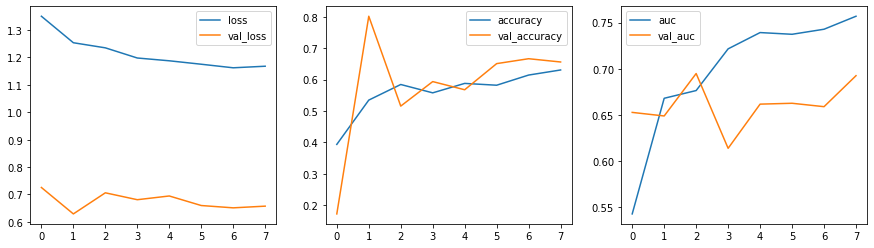

In [30]:
plot(history)

### Summary

1. The validation loss and training loss have come down gradually with every epoch
2. The accuracy is low but there is less underfitting observed. The accuracy can be improved further with more training samples or layers. However accuracy is not a right
measure for imbalanced data, we should try to improve AUC instead. 
3. Validation AUC also looks Ok, it can be better. 

With this model let us try predicting.

Please note the intention of this Notebook is not to achieve high accuracy, it is to teach how to run a CNN model using distributed ML techquies.
For practical purposes this accuracy will note be sufficient.

## 3. Making a Prediction

In [31]:
from tensorflow.keras.models import load_model

# Loading the weights from the best model.
cnn.load_weights('models/best_model.hdf5')

/var/tmp/effusion/data/effusion/00007520_000.png
Effusion detected, % of confidence:  64.47


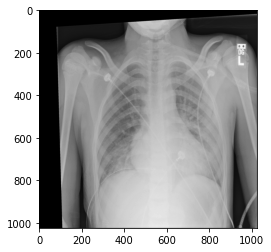

In [32]:
validation_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
validations = glob.glob(validation_path)
image_id = np.random.randint(0, len(validations))
print(validations[image_id])
validation = cv2.imread(validations[image_id], cv2.IMREAD_GRAYSCALE)
plt.imshow(validation,cmap='gray')
img = preprocess_img(validation[:, :, np.newaxis], 'validation')
print('Effusion detected, % of confidence: ', round(cnn.predict(img[np.newaxis,:])[0][0] * 100,2))

## 4. Submitting Experiments using ScriptRunConfig

From the above experiements we find out the best model and create a training script

__What is ScriptRunConfig?__
- A ScriptRunConfig object is used to configure the information necessary for submitting a training run as part of an Experiment.
- A ScriptRunConfig packages together the configuration information needed to submit a run in Azure ML, including the script, compute target, environment, and any distributed job-specific configs.

More details: https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.scriptrunconfig?view=azure-ml-py


In [33]:
import os
from azureml.core import ScriptRunConfig
import shutil
from azureml.core import Experiment
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

## From the experiments above, the training script is extracted and stored in effusion_detector.py
## This is a manual process at the moment, although the notebook helps convert the code in cells to python scripts
project_folder = './effusion_detector'
os.makedirs(project_folder, exist_ok=True)
shutil.copy('effusion_detector.py', project_folder)

## Giving the experiment a name
experiment_name = 'tf-effusion-detector'
experiment = Experiment(ws, name=experiment_name)

## Choosing the environment the training script depends on, ML creates a docker image with the 
## dependencies declared below
tf_env = Environment("tensorflow-2.3-gpu")
packages = CondaDependencies.create(conda_packages=['scikit-learn','pip'],
                                    pip_packages=['azureml-defaults', 'opencv-python==3.3.0.9', 'matplotlib', 'keras<=2.3.1', 'azureml-sdk', 'azureml-widgets', 'tensorflow'])
tf_env.python.conda_dependencies = packages

## defining arguments
args = ['--data-folder', dataset.as_mount(), '--epochs', 20]

## choosing compute target, in this example we will choose single machine in the next one which is for distributed training we will choose a cluster with 4 nodes
compute_target = ComputeTarget(workspace=ws, name='gpu-instance-small')
src = ScriptRunConfig(source_directory=project_folder,
                      script='effusion_detector.py',
                      arguments=args,
                      compute_target=compute_target,
                      environment=tf_env)

run = experiment.submit(src)
print(run)
run.get_details()


Run(Experiment: tf-effusion-detector,
Id: tf-effusion-detector_1621081608_4fe7f8b6,
Type: azureml.scriptrun,
Status: Preparing)


{'runId': 'tf-effusion-detector_1621081608_4fe7f8b6',
 'target': 'gpu-instance-small',
 'status': 'Preparing',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '52295cdf-7227-4333-a1c9-d560485f0190',
  'azureml.git.repository_uri': 'https://github.com/sriksmachi/octopus.git',
  'mlflow.source.git.repoURL': 'https://github.com/sriksmachi/octopus.git',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': '350a13c17e02d0a6b1e1cbc41d88390723744e28',
  'mlflow.source.git.commit': '350a13c17e02d0a6b1e1cbc41d88390723744e28',
  'azureml.git.dirty': 'False'},
 'inputDatasets': [{'dataset': {'id': '936fc596-dc32-48e8-8ba5-dcbc3bf2b310'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input__b7001421', 'mechanism': 'Mount'}}],
 'outputDatasets': [],
 'runDefinition': {'script': 'effusion_detector.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--data-folder',
   'DatasetConsumptionConfig:in

In [34]:
from azureml.widgets import RunDetails

# Dislay training log
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'NOTSET',…

## 5. Distributed Machine Learning using Horovod

The top 2 ways of training deep learning models in distributed fashion is using data-parallel and model-parallel approaches.
Currently the most common scenario is data-parallel training with synchronous updates. This approach is the easiest to implement and is sufficient for most use cases.

In this section we will convert the training script run on distributed ML environment created using Horovod.

__What is Horovod?__

Horovod is a distributed deep learning training framework for TensorFlow, Keras, PyTorch, and Apache MXNet. The goal of Horovod is to make distributed deep learning fast and easy to use.

https://github.com/horovod/horovod






In [35]:
import os
from azureml.core import ScriptRunConfig
import shutil
from azureml.core import Experiment
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.widgets import RunDetails
from azureml.core.runconfig import MpiConfiguration

## The training script capable of running in distributed environment is extracted to effusion_detector_distributed.py
project_folder = './effusion_detector-distributed'
os.makedirs(project_folder, exist_ok=True)
shutil.copy('effusion_detector_distributed.py', project_folder)

## choosing an experiment name
experiment_name = 'tf-distributed-effusion-detector'
experiment = Experiment(ws, name=experiment_name)

# loading the env dependencies from conda configuration
os.makedirs('./envs', exist_ok=True)
tf_env = Environment.from_conda_specification(name="imageclassification", file_path="envs/distributed-tensorflow-with-horovod/conda_dependencies.yml")

# Specify a GPU base image
tf_env.docker.enabled = True
tf_env.docker.base_image = 'mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.1-cudnn7-ubuntu18.04'

# using a cluster which can autoscale uptp 4 nodes.
cluster_name = "gpus"
compute_target = ComputeTarget(workspace=ws, name=cluster_name)

# running the script
args = ['--data-folder', dataset.as_mount(), '--epochs', 20]
src = ScriptRunConfig(source_directory=project_folder,
                      script='effusion_detector_distributed.py',
                      arguments=args,
                      compute_target=compute_target,
                      environment=tf_env, distributed_job_config=MpiConfiguration(node_count=4))

run = experiment.submit(src)
print(run)
run.get_details()

'enabled' is deprecated. Please use the azureml.core.runconfig.DockerConfiguration object with the 'use_docker' param instead.


Run(Experiment: tf-distributed-effusion-detector,
Id: tf-distributed-effusion-detector_1621081615_407d41d4,
Type: azureml.scriptrun,
Status: Preparing)


{'runId': 'tf-distributed-effusion-detector_1621081615_407d41d4',
 'target': 'gpus',
 'status': 'Preparing',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'acc16e72-9489-423f-bd90-778e444e17f5',
  'azureml.git.repository_uri': 'https://github.com/sriksmachi/octopus.git',
  'mlflow.source.git.repoURL': 'https://github.com/sriksmachi/octopus.git',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': '350a13c17e02d0a6b1e1cbc41d88390723744e28',
  'mlflow.source.git.commit': '350a13c17e02d0a6b1e1cbc41d88390723744e28',
  'azureml.git.dirty': 'False'},
 'inputDatasets': [{'dataset': {'id': '936fc596-dc32-48e8-8ba5-dcbc3bf2b310'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input__99e4f6dd', 'mechanism': 'Mount'}}],
 'outputDatasets': [],
 'runDefinition': {'script': 'effusion_detector_distributed.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--data-folder',
   'DatasetConsumptio

In [36]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'NOTSET',…